Procesando frame 240/240

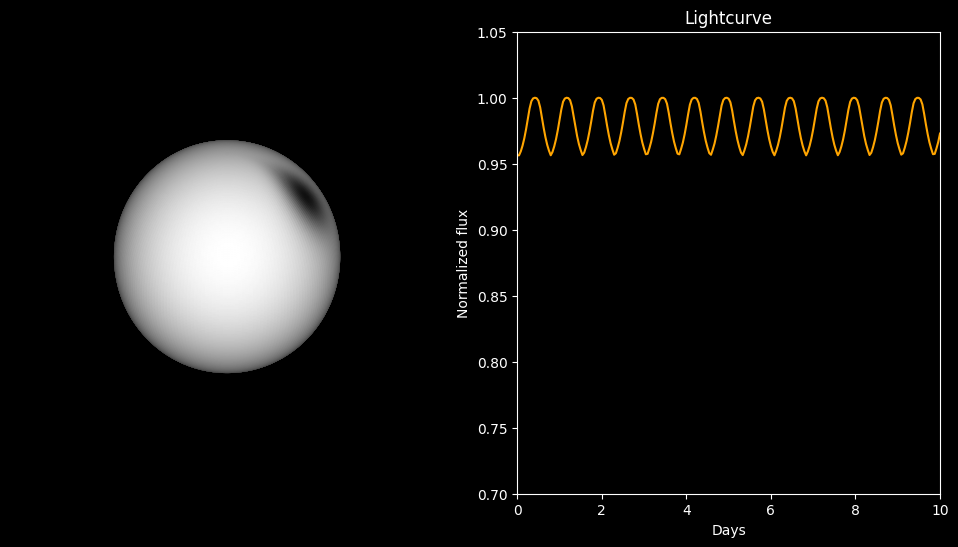

In [7]:
%matplotlib inline

import numpy as np
import pandas as pd
import astropy.units as u
from astropy.constants import R_sun
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from sklearn.preprocessing import normalize

# Stellar parameters 
r = 1* u.R_sun
res = 200
constant = 0.8  # limb darkening coefficient

#creating angles
theta = np.linspace(0, 2*np.pi, res)
phi = np.linspace(0, np.pi, res)

#meshgrid for creation of the sphere surface
theta_mesh, phi_mesh = np.meshgrid(theta, phi)

x = r * np.sin(phi_mesh) * np.cos(theta_mesh)
y = r * np.sin(phi_mesh) * np.sin(theta_mesh)
z = r * np.cos(phi_mesh)

# gray texture 
gray_texture = np.ones((res, res))  # intensidad 1 = blanco

# parameters position of the spot
spot_theta_deg = 0#------>Longitude
spot_phi_deg = 45#------>Latitude
spot_radius_deg = 25

#Parameter of differential rotation
omega_eq =   2.9*np.pi   # angular velocity in equator
delta_omega = 0.5 * np.pi  # Difference between equator and pole

#parameters of how many days periods/total_frame
observing_baseline_days=10
total_frame=240 #------> 0.041days/frame



# convertion function 
def convertion_radians(degree):
    return np.deg2rad(degree)
    
                                                                
spot_phi_rad = convertion_radians(spot_phi_deg)
spot_radius_rad = convertion_radians(spot_radius_deg)
spot_theta_rad = convertion_radians(spot_theta_deg)

# Point of view of the sphere

elev = 30
azim = 0

elev_rad = convertion_radians(elev)
azim_rad = convertion_radians(azim)

v_x = np.cos(elev_rad) * np.cos(azim_rad)
v_y = np.cos(elev_rad) * np.sin(azim_rad)
v_z = np.sin(elev_rad)

# Limb darkening
mu = (x * v_x + y * v_y + z * v_z) / r
mu = np.clip(mu, 0, 1)


# limb darkening function 
def limbdarkening(u):
    return (1 - u * (1 - mu))
lineal_darkening = limbdarkening(constant)
gray_texture *= lineal_darkening

#movement function
# def get_spot_theta_rad(initial_deg, angular_velocity, frame, total_frames):
#     initial_rad = np.deg2rad(initial_deg)
#     delta_theta = angular_velocity * np.pi * frame / total_frames
#     return initial_rad + delta_theta
    
def spot_theta(days,initial_rad, spot_phi_rad, omega_eq, delta_omega, frame, total_frames):
    """
    Initial position of the spots.
    
    Parameters:
    - initial_deg: initial position of spot.
    - spot_phi_rad: latitud of spot(radians)
    - omega_eq: angular velocity.
    - delta_omega: difference between velocity in pole and equator.
    - frame: actual frame.
    - total_frames:.
    Returns:
    - theta in radians.
    """
    delta_t = days / total_frames
    time = frame * delta_t
    #Period will be depends on two peaks of observation 
     # differential rotation
    
    omega_phi = omega_eq - delta_omega * np.sin(spot_phi_rad)**2
    delta_theta = omega_phi * time
    
    return initial_rad + delta_theta



def flux_plot(flux):
    ''' Function take a list normalizing the flux, converting the list in a csv file and rename the columns
    and return a plot    
    '''
    flux_norm = normalize([flux], norm="max")[0]
    df = pd.DataFrame(flux_norm)
    df.to_csv("lc_high.csv")
    lc = pd.read_csv("lc_high.csv")
    lc = lc.rename(columns={'Unnamed: 0': 'Days', '0': 'flux_normalized'})#-----> change the name of the columns
    lc.to_csv('lc_high_name.csv')
    return lc.plot(x="Days", y="flux_normalized", alpha=0.5)#----->simple plot of lc


def spot_mask(theta_mesh, spot_theta_rad,phi_mesh,spot_phi_rad):
    '''function for creating spot mask, that could change the size and shape of the spot
    using a gaussian function
    '''
    delta_theta = np.arccos(np.cos(theta_mesh - spot_theta_rad))
    delta_phi = np.abs(phi_mesh - spot_phi_rad)
    distance_squared = delta_theta**2 + delta_phi**2
    sigma_squared = (spot_radius_rad / 2)**2
    return np.exp(-distance_squared / (2 * sigma_squared))
    

    
# Figura
plt.style.use('dark_background')# -----> dark background
fig = plt.figure(figsize=(12, 6))

ax_sphere = fig.add_subplot(121, projection='3d')
ax_curve = fig.add_subplot(122)
ax_sphere.set_box_aspect((0.98, 1, 0.95))#-------> symtries of the sun 
ax_sphere.set_axis_off()

ax_curve.set_title('Lightcurve', color='white')
ax_curve.set_xlabel('Days')
ax_curve.set_ylabel('Normalized flux')
ax_curve.set_xlim(0, days)
ax_curve.set_ylim(0.7, 1.05)
ax_curve.set_facecolor('black')
line_curve, = ax_curve.plot([], [], color='orange')

# Flux saves
fluxes = []

#

def animate(i):
    ax_sphere.clear()
    ax_sphere.set_axis_off()
    ax_sphere.view_init(elev=elev, azim=azim)

 
    texture = np.copy(gray_texture)


    spot_theta_motion = spot_theta(days,spot_theta_rad, spot_phi_rad, omega_eq, delta_omega,i,total_frame)
    

    spot_mask_motion = spot_mask(theta_mesh, spot_theta_motion, phi_mesh, spot_phi_rad)

    # Aplicar mancha oscura
    texture *= (1 - 0.9 * spot_mask_motion)


    # Dibujar la superficie
    #surf = ax_sphere.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=texture, shade=False)
    surf = ax_sphere.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=plt.cm.gray(texture), shade=False)
    
    visible = mu > 0
    total_flux = np.sum(texture[visible])
    fluxes.append(total_flux)

     #Normalizar e ingresar a la curva
    fluxes_normalized = normalize([fluxes], norm="max")[0]
    line_curve.set_data(np.arange(len(fluxes))*days/total_frame, fluxes_normalized)
    #line_curve.set_data(np.arange(len(fluxes)), fluxes)

    #return [surf, line_curve]
    
    print(f"Procesando frame {i+1}/{total_frame}", end='\r')  # -------> to see the process
        

    return[surf, line_curve]


ani = animation.FuncAnimation(fig, animate, frames=total_frame, interval=60, blit=False,repeat =False)
ani.save('spot_high_period.gif', writer='ffmpeg', fps=20)
plt.show()


<Axes: xlabel='Days'>

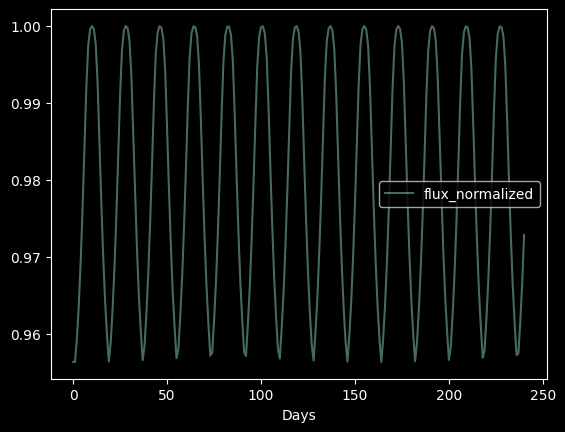

In [8]:
flux_plot(fluxes)

Procesando frame 2/240

MovieWriter stderr:
Error writing trailer of spot_high_period_def_corrected.gif: Invalid argument



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1200x600', '-pix_fmt', 'rgba', '-framerate', '20', '-loglevel', 'error', '-i', 'pipe:', '-filter_complex', 'split [a][b];[a] palettegen [p];[b][p] paletteuse', '-y', 'spot_high_period_def_corrected.gif']' returned non-zero exit status 255.

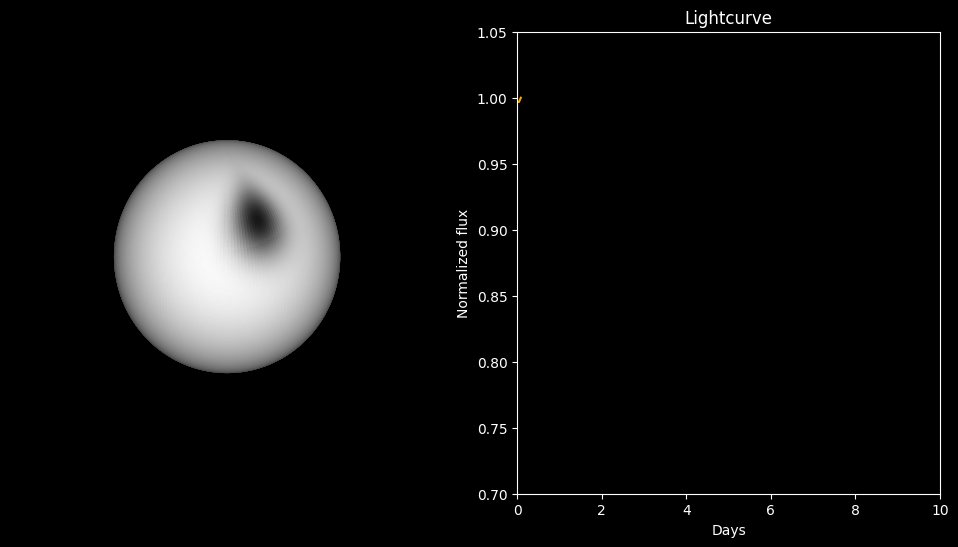

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import astropy.units as u
from astropy.constants import R_sun
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from sklearn.preprocessing import normalize
from line_profiler import profile

#---->Functions
@profile
def convertion_radians(degree):
    ''' convertions degree to radians'''
    return np.deg2rad(degree)
    
@profile
def limbdarkening(mu, u):
    '''Limb darkening lineal model'''
    return (1 - u * (1 - mu))
    
@profile
def spot_theta(days, initial_rad, spot_phi_rad, omega_eq, delta_omega, frame, total_frames):
    """
    Function to calculate the motion of the spots and the differential rotation
    Initial position of the spots.
    Parameters:
    -days
    - initial_deg: initial position of spot.
    - spot_phi_rad: latitud of spot(radians)
    - omega_eq: angular velocity.
    - delta_omega: difference between velocity in pole and equator.
    - frame: actual frame.
    - total_frames:.
    Returns:
    - theta in radians.
    """  
    delta_t = days/total_frame
    time = frame * delta_t

    ##Differential Rotation
    omega_phi = omega_eq - delta_omega * np.sin(spot_phi_rad)**2#---->sunlike star
    delta_theta_d = omega_phi * time
    return initial_rad + delta_theta_d



@profile
def spot_mask(theta_mesh, spot_theta_rad, phi_mesh, spot_phi_rad, spot_radius_rad):
    '''function for creating spot mask, that could change the size and shape of the spot
    using a gaussian function
    '''
    delta_theta = np.arccos(np.cos(theta_mesh - spot_theta_rad))
    delta_phi = np.abs(phi_mesh - spot_phi_rad)
    distance_squared = delta_theta**2 + delta_phi**2
    sigma_squared = (spot_radius_rad / 2)**2
    return np.exp(-distance_squared / (2 * sigma_squared))

@profile
def flux_plot(flux):
    ''' Function take a list normalizing the flux, converting the list in a csv file and rename the columns
    and return a plot    
    '''
    flux_norm = normalize([flux], norm="max")[0]
    df = pd.DataFrame(flux_norm)
    df.to_csv("lc_high.csv")
    lc = pd.read_csv("lc_high.csv")
    lc = lc.rename(columns={'Unnamed: 0': 'Days', '0': 'flux_normalized'})
    lc.to_csv('lc_high_name.csv')
    return lc.plot(x="Days", y="flux_normalized", alpha=0.5)

# === Animation function ===
@profile
def animate(i, gray_texture, mu, spot_theta_rad, spot_phi_rad, spot_radius_rad,
            theta_mesh, phi_mesh, x, y, z, ax_sphere, elev, azim, ax_curve, line_curve, fluxes,
            days, omega_eq, delta_omega, total_frame):
    """ Function where is created the motion and call functions"""
    
    ax_sphere.clear()
    ax_sphere.set_axis_off()
    ax_sphere.view_init(elev=elev, azim=azim)

    texture = np.copy(gray_texture)
    spot_theta_motion = spot_theta(days, spot_theta_rad, spot_phi_rad, omega_eq, delta_omega, i, total_frame)
    spot_mask_motion = spot_mask(theta_mesh, spot_theta_motion, phi_mesh, spot_phi_rad, spot_radius_rad)
    
    #applying texture to the spot
    texture *= (1 - 0.9 * spot_mask_motion)
    
    #plotting the surface
    surf = ax_sphere.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=plt.cm.gray(texture), shade=False)
    
    #taking only visible part
    visible = mu > 0
    total_flux = np.sum(texture[visible])
    fluxes.append(total_flux)

    #Normalized fluz for plot
    fluxes_normalized = normalize([fluxes], norm="max")[0]
    line_curve.set_data(np.arange(len(fluxes))*days/total_frame, fluxes_normalized)

    print(f"Procesando frame {i+1}/{total_frame}", end='\r')
    return [surf, line_curve]

#------->main
if __name__ == '__main__':
    # Parameters
    r = 1 * u.R_sun#------->solar like radii
    res = 200#--------->resolution
    constant = 0.8#---------->limb darkening coefficient
    spot_theta_deg = 0#------->longitude
    spot_phi_deg = 45#--------->latitude
    spot_radius_deg = 25#------->radii spot
    #parameters of motion
    omega_eq = 2.9 * np.pi#------>equator angular velocity
    delta_omega = 0.5 * np.pi#----->difference between equator and pole velocity
    days = 10#----->days that you want to put
    total_frame = 240#-------->how many frames do you wants
    elev = 30#-------->elevation angle
    azim = 0#-------->doesn't affect

    # Conversion parameters
    spot_phi_rad = convertion_radians(spot_phi_deg)
    spot_radius_rad = convertion_radians(spot_radius_deg)
    spot_theta_rad = convertion_radians(spot_theta_deg)
    elev_rad = convertion_radians(elev)
    azim_rad = convertion_radians(azim)

    # Meshgrid
    theta = np.linspace(0, 2*np.pi, res)
    phi = np.linspace(0, np.pi, res)
    theta_mesh, phi_mesh = np.meshgrid(theta, phi)
    x = r * np.sin(phi_mesh) * np.cos(theta_mesh)
    y = r * np.sin(phi_mesh) * np.sin(theta_mesh)
    z = r * np.cos(phi_mesh)

    # Point of view of limb darkening
    v_x = np.cos(elev_rad) * np.cos(azim_rad)
    v_y = np.cos(elev_rad) * np.sin(azim_rad)
    v_z = np.sin(elev_rad)
    mu = (x * v_x + y * v_y + z * v_z) / r
    mu = np.clip(mu, 0, 1)

    # Texture for limb darkening
    gray_texture = np.ones((res, res))
    gray_texture *= limbdarkening(mu, constant)

    # Plot figure
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(12, 6))
    ax_sphere = fig.add_subplot(121, projection='3d')
    ax_curve = fig.add_subplot(122)
    ax_sphere.set_box_aspect((0.98, 1, 0.95))
    ax_sphere.set_axis_off()
    ax_curve.set_title('Lightcurve', color='white')
    ax_curve.set_xlabel('Days')
    ax_curve.set_ylabel('Normalized flux')
    ax_curve.set_xlim(0, days)
    ax_curve.set_ylim(0.7, 1.05)
    ax_curve.set_facecolor('black')
    line_curve, = ax_curve.plot([], [], color='orange')
    
    #list for saving fluxes
    fluxes = []

    ani = animation.FuncAnimation(
        fig, animate, frames=total_frame, interval=60, blit=False, repeat=False,
        fargs=(gray_texture, mu, spot_theta_rad, spot_phi_rad, spot_radius_rad,
               theta_mesh, phi_mesh, x, y, z, ax_sphere, elev, azim, ax_curve,
               line_curve, fluxes, days, omega_eq, delta_omega, total_frame)
    )

    ani.save('spot_high_period_def_corrected.gif', writer='ffmpeg', fps=20)
    plt.show()



🌀 Período de rotación detectado: 0.772 días


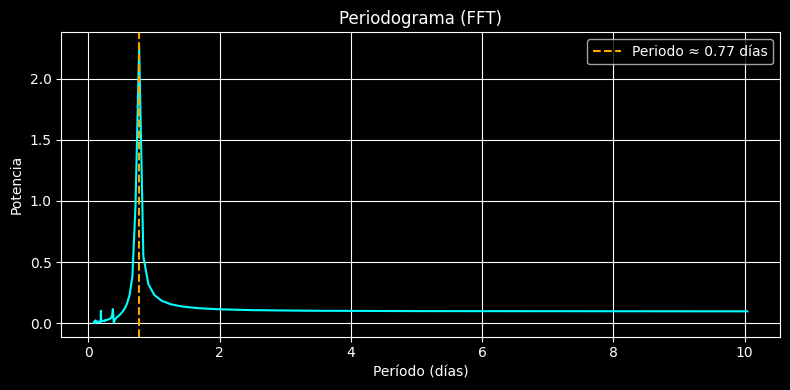

In [39]:
# ========== Análisis de periodo con FFT ==========
from scipy.fft import rfft, rfftfreq
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

# Verificamos si hay datos suficientes
if len(fluxes) > 10:

    # Normalizar flujo
    flux_norm = normalize([fluxes], norm='max')[0]

    # Eje de tiempo en días (tenés 240 frames en 10 días)
    tiempo = np.linspace(0, days, len(fluxes))  # Esto está en días
    N = len(tiempo)
    dt = tiempo[1] - tiempo[0]  # paso temporal en días

    # FFT
    frecuencias = rfftfreq(N, dt)
    espectro = np.abs(rfft(flux_norm - np.mean(flux_norm)))

    # Ignoramos la frecuencia cero (promedio)
    frecuencias = frecuencias[1:]
    espectro = espectro[1:]

    # Buscamos frecuencia dominante
    indice_pico = np.argmax(espectro)
    frecuencia_dominante = frecuencias[indice_pico]
    periodo_dominante = 1 / frecuencia_dominante

    print(f"\n🌀 Período de rotación detectado: {periodo_dominante:.3f} días")

    # Graficamos el periodograma
    plt.figure(figsize=(8, 4))
    plt.plot(1 / frecuencias, espectro, color='cyan')
    plt.axvline(periodo_dominante, color='orange', linestyle='--',
                label=f"Periodo ≈ {periodo_dominante:.2f} días")
    plt.xlabel("Período (días)")
    plt.ylabel("Potencia")
    plt.title("Periodograma (FFT)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("⚠️ No se encontraron suficientes datos de flujo para estimar el período.")


Procesando frame 240/240

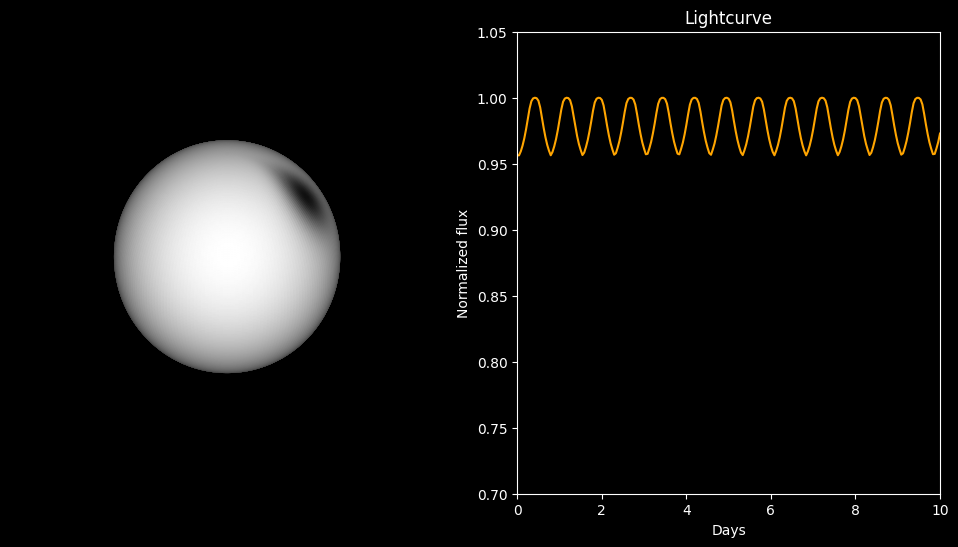

In [6]:
class StarSpotModel:
    def __init__(self, r=1*u.R_sun, res=200, days=10, total_frames=240,
                 spot_theta_deg=0, spot_phi_deg=45, spot_radius_deg=25,
                 omega_eq=2.9*np.pi, delta_omega=0.5*np.pi,
                 elev=30, azim=0, limb_darkening_coeff=0.8):
        
        self.r = r
        self.res = res
        self.days = days
        self.total_frames = total_frames
        self.omega_eq = omega_eq
        self.delta_omega = delta_omega
        self.elev = elev
        self.azim = azim
        self.constant = limb_darkening_coeff
        
        # Manchas
        self.spot_theta_rad = np.deg2rad(spot_theta_deg)
        self.spot_phi_rad = np.deg2rad(spot_phi_deg)
        self.spot_radius_rad = np.deg2rad(spot_radius_deg)
        
        # Malla
        self.theta = np.linspace(0, 2*np.pi, res)
        self.phi = np.linspace(0, np.pi, res)
        self.theta_mesh, self.phi_mesh = np.meshgrid(self.theta, self.phi)
        self.x = self.r * np.sin(self.phi_mesh) * np.cos(self.theta_mesh)
        self.y = self.r * np.sin(self.phi_mesh) * np.sin(self.theta_mesh)
        self.z = self.r * np.cos(self.phi_mesh)

        # Ángulo de visión
        elev_rad = np.deg2rad(elev)
        azim_rad = np.deg2rad(azim)
        self.v_x = np.cos(elev_rad) * np.cos(azim_rad)
        self.v_y = np.cos(elev_rad) * np.sin(azim_rad)
        self.v_z = np.sin(elev_rad)

        # Limb darkening
        self.mu = (self.x * self.v_x + self.y * self.v_y + self.z * self.v_z) / self.r
        self.mu = np.clip(self.mu, 0, 1)
        self.gray_texture = np.ones((res, res)) * (1 - self.constant * (1 - self.mu))
        
        self.fluxes = []

    def compute_spot_theta(self, frame):
        delta_t = self.days / self.total_frames
        time = frame * delta_t
        omega_phi = self.omega_eq - self.delta_omega * np.sin(self.spot_phi_rad)**2
        return self.spot_theta_rad + omega_phi * time

    def compute_spot_mask(self, theta_rad):
        delta_theta = np.arccos(np.cos(self.theta_mesh - theta_rad))
        delta_phi = np.abs(self.phi_mesh - self.spot_phi_rad)
        distance_squared = delta_theta**2 + delta_phi**2
        sigma_squared = (self.spot_radius_rad / 2)**2
        return np.exp(-distance_squared / (2 * sigma_squared))

    def compute_flux(self, texture):
        visible = self.mu > 0
        return np.sum(texture[visible])
        
def animate(i, model, ax_sphere, ax_curve, line_curve):
    ax_sphere.clear()
    ax_sphere.set_axis_off()
    ax_sphere.view_init(elev=model.elev, azim=model.azim)

    texture = np.copy(model.gray_texture)
    theta_spot = model.compute_spot_theta(i)
    mask = model.compute_spot_mask(theta_spot)
    texture *= (1 - 0.9 * mask)

    surf = ax_sphere.plot_surface(model.x, model.y, model.z, rstride=1, cstride=1,
                                   facecolors=plt.cm.gray(texture), shade=False)

    total_flux = model.compute_flux(texture)
    model.fluxes.append(total_flux)

    fluxes_norm = normalize([model.fluxes], norm='max')[0]
    time_days = np.linspace(0, model.days, len(fluxes_norm))
    line_curve.set_data(time_days, fluxes_norm)

    print(f"Procesando frame {i+1}/{model.total_frames}", end='\r')
    return [surf, line_curve]
    
if __name__ == '__main__':
    model = StarSpotModel()

    plt.style.use('dark_background')
    fig = plt.figure(figsize=(12, 6))
    ax_sphere = fig.add_subplot(121, projection='3d')
    ax_curve = fig.add_subplot(122)
    ax_sphere.set_box_aspect((0.98, 1, 0.95))
    ax_curve.set_xlim(0, model.days)
    ax_curve.set_ylim(0.7, 1.05)
    ax_curve.set_facecolor("black")
    ax_curve.set_title("Lightcurve", color="white")
    ax_curve.set_xlabel("Days")
    ax_curve.set_ylabel("Normalized flux")
    line_curve, = ax_curve.plot([], [], color="orange")

    ani = animation.FuncAnimation(fig, animate, frames=model.total_frames, interval=60, blit=False,
                                   repeat=False, fargs=(model, ax_sphere, ax_curve, line_curve))

    ani.save('spot_model_class.gif', writer='ffmpeg', fps=20)
    plt.show()



In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import astropy.units as u
from astropy.constants import R_sun
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from sklearn.preprocessing import normalize

# Stellar parameters 
r = 1* u.R_sun
res = 200
constant = 0.8  # limb darkening coefficient

#creating angles
theta = np.linspace(0, 2*np.pi, res)
phi = np.linspace(0, np.pi, res)

#meshgrid for creation of the sphere surface
theta_mesh, phi_mesh = np.meshgrid(theta, phi)

x = r * np.sin(phi_mesh) * np.cos(theta_mesh)
y = r * np.sin(phi_mesh) * np.sin(theta_mesh)
z = r * np.cos(phi_mesh)

# gray texture 
gray_texture = np.ones((res, res))  # intensidad 1 = blanco

# parameters position of the spot
spot_theta_deg = 0#------>Longitude
spot_phi_deg = 30#------>Latitude
spot_radius_deg = 25

#Parameter of differential rotation
omega_eq = 10 * np.pi   # angular velocity in equator
delta_omega = 0.5 * np.pi  # Difference between equator and pole



# convertion function 
def convertion_radians(degree):
    return np.deg2rad(degree)
    
spot_phi_rad = convertion_radians(spot_phi_deg)
spot_radius_rad = convertion_radians(spot_radius_deg)
spot_theta_rad = convertion_radians(spot_theta_deg)

# Point of view of the sphere
elev = 0
azim = 0

elev_rad = convertion_radians(elev)
azim_rad = convertion_radians(azim)

v_x = np.cos(elev_rad) * np.cos(azim_rad)
v_y = np.cos(elev_rad) * np.sin(azim_rad)
v_z = np.sin(elev_rad)

# Limb darkening
mu = (x * v_x + y * v_y + z * v_z) / r
mu = np.clip(mu, 0, 1)

# limb darkening function 
def limbdarkening(u):
    return (1 - u * (1 - mu))
lineal_darkening = limbdarkening(constant)
gray_texture *= lineal_darkening


def spot_theta(initial_rad, spot_phi_rad, omega_eq, delta_omega, frame, total_frames):
    """
    Initial position of the spots.
    
    Parameters:
    - initial_deg: initial position of spot.
    - spot_phi_rad: latitud of spot(radians)
    - omega_eq: angular velocity.
    - delta_omega: difference between velocity in pole and equator.
    - frame: actual frame.
    - total_frames:.
    Returns:
    - theta in radians.
    """
    # differential rotation
    omega_phi = omega_eq - delta_omega * np.sin(spot_phi_rad)**2
    # Avance angular acumulado
    delta_theta = omega_phi * frame / total_frames
    return initial_rad + delta_theta


def flux_plot(flux):
    ''' Function take a list normalizing the flux, converting the list in a csv file and rename the columns
    and return a plot    
    '''
    flux_norm = normalize([flux], norm="max")[0]
    df = pd.DataFrame(flux_norm)
    df.to_csv("lc_high.csv")
    lc = pd.read_csv("lc_high.csv")
    lc = lc.rename(columns={'Unnamed: 0': 'Days', '0': 'flux_normalized'})#-----> change the name of the columns
    return lc.plot(x="Days", y="flux_normalized", alpha=0.5)#----->simple plot of lc


def spot_mask(theta_mesh, spot_theta_rad,phi_mesh,spot_phi_rad):
    '''function for creating spot mask, that could change the size and shape of the spot
    using a gaussian function
    '''
    delta_theta = np.arccos(np.cos(theta_mesh - spot_theta_rad))
    delta_phi = np.abs(phi_mesh - spot_phi_rad)
    distance_squared = delta_theta**2 + delta_phi**2
    sigma_squared = (spot_radius_rad / 2)**2
    return np.exp(-distance_squared / (2 * sigma_squared))
    

    
# Defining Figure
plt.style.use('dark_background')# -----> dark background
fig = plt.figure(figsize=(12, 6))

ax_sphere = fig.add_subplot(121, projection='3d')
ax_curve = fig.add_subplot(122)
ax_sphere.set_box_aspect((0.98, 1, 0.95))#-------> symtries of the sun 
ax_sphere.set_axis_off()

ax_curve.set_title('Lightcurve', color='white')
ax_curve.set_xlabel('Days')
ax_curve.set_ylabel('Normalized flux')
ax_curve.set_xlim(0, 240)
ax_curve.set_ylim(0.7, 1.05)
ax_curve.set_facecolor('black')
line_curve, = ax_curve.plot([], [], color='orange')

# Flux savings
fluxes = []


def animate(i):
    ax_sphere.clear()
    ax_sphere.set_axis_off()
    ax_sphere.view_init(elev=elev, azim=azim)

    # texture copy
    texture = np.copy(gray_texture)

    # movement of the spot
    spot_theta_motion = spot_theta(spot_theta_rad, spot_phi_rad, omega_eq, delta_omega,i,240)
    spot_mask_motion = spot_mask(theta_mesh, spot_theta_motion, phi_mesh, spot_phi_rad)

    # Aplying mask to the spot 
    texture *= (1 - 0.9 * spot_mask_motion)
    
    # draw surface
    surf = ax_sphere.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=plt.cm.gray(texture), shade=False)
    
    #adding only visible to flux
    visible = mu > 0
    total_flux = np.sum(texture[visible])
    fluxes.append(total_flux)

     #Normalized
    fluxes_normalized = normalize([fluxes], norm="max")[0]
    line_curve.set_data(np.arange(len(fluxes)), fluxes_normalized)
    
    print(f"Procesando frame {i+1}/240", end='\r')  # -------> to see the process
    return[surf, line_curve]
    
#animation and saving gif
ani = animation.FuncAnimation(fig, animate, frames=240, interval=60, blit=False,repeat =False)
ani.save('spot_high.gif', writer='ffmpeg', fps=20)
plt.show()


Procesando frame 240/240